In [1]:
import mlflow
mlflow.end_run() 
mlflow.set_tracking_uri(uri="http://localhost:5000")




In [2]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split




In [6]:
# Chargement des données
#data = pd.read_csv('/home/machou/openclassroom/mlflow_project/data/data_preprocessed_train.csv')
#test_data = pd.read_csv('/home/machou/openclassroom/mlflow_project/data/application_test.csv')


X_train = pd.read_csv('/home/machou/openclassroom/mlflow_project/data/X_train_cleaned.csv')
X_test = pd.read_csv('/home/machou/openclassroom/mlflow_project/data/X_test_cleaned.csv')
y_train = pd.read_csv('/home/machou/openclassroom/mlflow_project/data/y_train_cleaned.csv')





In [4]:
# Séparation de la cible (TARGET) et des caractéristiques (features)
X_train = data_train.drop(columns=['TARGET'])
y_train = data_train['TARGET']
X_test = data_test  # Pas de TARGET dans data_test


### Model Xgboost with smote an score metier

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score
import joblib
import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline

# Exemple : X_train = train_data.drop(columns=['TARGET']), y_train = train_data['TARGET']
# Vérifiez le type et les valeurs de y_train
#print(y_train.head())
#print(y_train.unique())


# Division des données d'entraînement en X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train , test_size=0.2, random_state=42, stratify=y_train)


# Si la cible est continue, convertir en binaire (ajustez le seuil si nécessaire)
y_train = (y_train > 0.5).astype(int)  # Transformation en binaire

# 1. Définir les variables catégorielles dans le dataset
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# 2. Transformation des variables catégorielles et numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Imputer les NaN dans les variables numériques
            ('scaler', StandardScaler())  # Standardiser les variables numériques
        ]), X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputer les NaN dans les variables catégorielles
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))  # Encodage des variables catégorielles
        ]), categorical_features)
    ])

# 3. SMOTE pour équilibrer les classes
smote = SMOTE(sampling_strategy=0.4, random_state=42)

# 4. Modèle XGBoost
model_xgb = xgb.XGBClassifier(random_state=42, scale_pos_weight=10)

# 5. Créer un pipeline avec SMOTE dans un pipeline ImbPipeline
pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),  # Prétraitement des données
    ('smote', smote),  # SMOTE pour suréchantillonner les classes minoritaires
    ('model', model_xgb)  # XGBoost
])

# Fonction de coût métier (10 * FN + FP)
def cost_function(y_true, y_pred_proba, threshold=0.5):
    # Convertir les probabilités en classes binaires en fonction du seuil
    y_pred_bin = (y_pred_proba >= threshold).astype(int)
    
    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    
    # Coût métier : 10 * FN + FP
    return 10 * fn + fp

# Score personnalisé basé sur la fonction de coût métier
def custom_cost_score(y_true, y_pred_proba, threshold=0.5):
    return -cost_function(y_true, y_pred_proba, threshold)

# Créer un scorer pour la fonction de coût métier
custom_scorer = make_scorer(custom_cost_score, greater_is_better=False)

# Score pour l'AUC (à ajouter pour contrôle)
def auc_score(y_true, y_pred_proba):
    return roc_auc_score(y_true, y_pred_proba)

# Créer un scorer pour l'AUC
auc_scorer = make_scorer(auc_score, greater_is_better=True)

# Score pour l'accuracy (à ajouter pour contrôle)
def accuracy_score_custom(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Créer un scorer pour l'accuracy
accuracy_scorer = make_scorer(accuracy_score_custom, greater_is_better=True)

# 6. Recherche d'hyperparamètres avec GridSearchCV (optionnel)
param_grid = {
   'model__n_estimators': [140],
    'model__max_depth': [10],
    'model__learning_rate': [0.04],
    #'model__subsample': [1.0],
    'model__colsample_bytree': [1.0],
    'model__gamma': [0.2],
   # 'model__min_child_weight': [5],
   # 'model__reg_alpha': [0.01],  # L1 Regularization
   # 'model__reg_lambda': [1.0],
}

grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=StratifiedKFold(n_splits=5), 
                           scoring=custom_scorer, n_jobs=-1)


In [16]:

# Entraîner le modèle avec la recherche des meilleurs hyperparamètres
grid_search.fit(X_train, y_train)



/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SK_ID_CURR',
                                                                          'CNT_CHILDREN',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'AMT_CREDIT',
                                                                          'AMT_ANNUITY',
                                                                          'AMT_GOODS_PRICE',
                                                                          'REGION_POPULATION_RELATIV...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [1.0],
                         'model__gamma': [0.2], 'model__learning_rate': [0.04],
                         'model__max_depth': [10],
                         'model__n_estimators': [140]},
             scoring=make_scorer(custom_cost_score, greater_is_better=False))

In [17]:
# 7. Résultats de la recherche
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score de coût métier:", -grid_search.best_score_)

# 8. Prédictions et évaluation
best_model = grid_search.best_estimator_

# Prédire sur les données de test
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

from sklearn.metrics import f1_score

# Calcul des prédictions sur X_test
y_pred_bin = best_model.predict(X_test)  # Classes prédites pour la précision et le F1-score
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Calcul de l'AUC (Area Under the Curve)
auc_score_xgb = roc_auc_score(y_test, y_pred_proba)

# Calcul de l'Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_bin)

# Calcul du F1-Score
f1_xgb = f1_score(y_test, y_pred_bin)

# Trouver le seuil optimal pour minimiser le coût métier
thresholds = np.arange(0.0, 1.05, 0.05)  # Tester des seuils de 0.0 à 1.0 par pas de 0.05
costs = [cost_function(y_test, y_pred_proba, threshold=t) for t in thresholds]  # Calculer le coût pour chaque seuil
best_threshold = thresholds[np.argmin(costs)]  # Trouver le seuil qui minimise le coût

# Affichage des résultats
print(f'AUC : {auc_score_xgb:.4f}')
print(f'Accuracy : {accuracy_xgb:.4f}')
print(f'F1-Score : {f1_xgb:.4f}')
print(f'Seuil optimal pour le score métier : {best_threshold:.4f}')


# Sauvegarder le modèle final
joblib.dump(best_model, '/home/machou/openclassroom/mlflow_project/models/xgb_model_with_smote_and_score_metier_etape_par_etape.pkl')


Meilleurs hyperparamètres: {'model__colsample_bytree': 1.0, 'model__gamma': 0.2, 'model__learning_rate': 0.04, 'model__max_depth': 10, 'model__n_estimators': 140}
Meilleur score de coût métier: -10399.2
AUC : 0.7459
Accuracy : 0.8040
F1-Score : 0.2857
Seuil optimal pour le score métier : 0.3500


['/home/machou/openclassroom/mlflow_project/models/xgb_model_with_smote_and_score_metier_etape_par_etape.pkl']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Prédictions binaires sur le jeu de test avec le seuil optimal trouvé
y_pred_test = (y_pred_proba >= best_threshold).astype(int)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_test)
labels = ['Classe 0 (Négatif)', 'Classe 1 (Positif)']

# Création de la heatmap avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Ajouter des titres et labels
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()


In [ ]:
### model mieux optimisé

In [50]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import joblib

# Exemple de données (remplacez par vos données)
# X_train = train_data.drop(columns=['TARGET'])
# y_train = train_data['TARGET']

# Vérification des données cibles
#print(y_train.head())
#print(y_train.unique())


# Identification des variables catégorielles et numériques
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Prétraitement des données
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Imputation des NaN (numériques)
            ('scaler', StandardScaler())  # Standardisation
        ]), numerical_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des NaN (catégoriques)
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))  # Encodage OneHot
        ]), categorical_features)
    ]
)

# Application du prétraitement
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


# Gestion des classes déséquilibrées avec SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# Initialisation du modèle XGBoost avec pondération des classes
model_xgb = xgb.XGBClassifier(random_state=42, scale_pos_weight=12)

# Pipeline complet : Prétraitement -> SMOTE -> Modèle
pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', model_xgb)
])

# Définition de la fonction de coût métier : 10 * FN + FP
def cost_function(y_true, y_pred_proba, threshold=0.5):
    y_pred_bin = (y_pred_proba >= threshold).astype(int)  # Conversion des probabilités en classes
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()  # Matrice de confusion
    return 10 * fn + fp  # Coût métier

# Création d'un scorer basé sur la fonction de coût
def custom_cost_score(y_true, y_pred_proba, threshold=0.5):
    return -cost_function(y_true, y_pred_proba, threshold)

custom_scorer = make_scorer(custom_cost_score, greater_is_better=False)

# Grille d'hyperparamètres pour GridSearchCV
param_grid = {
    'model__n_estimators': [ 220],
    'model__max_depth': [8],
    'model__learning_rate': [0.04],
    'model__colsample_bytree': [1.0],
    'model__gamma': [0.2],
    'model__subsample': [0.8],
    'model__scale_pos_weight': [15,10],  
    
}


# Grille d'hyperparamètres pour GridSearchCV
#param_grid = {
  # 'model__n_estimators': [160],
 #   'model__max_depth': [8],
 #   'model__learning_rate': [0.04],
    #'model__subsample': [1.0],
  #  'model__colsample_bytree': [1.0],
  #  'model__gamma': [0.2],
   # 'model__min_child_weight': [5],
   # 'model__reg_alpha': [0.01],  # L1 Regularization
   # 'model__reg_lambda': [1.0],
#}


# Recherche d'hyperparamètres avec validation croisée stratifiée
grid_search = GridSearchCV(
    pipeline_xgb,
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring=custom_scorer,
    n_jobs=-1
)

# Entraînement du modèle
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres et score associé
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score de coût métier:", -grid_search.best_score_)

# Prédictions sur les données de test
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Évaluation des performances
y_pred_bin = (y_pred_proba >= 0.5).astype(int)  # Classes prédictes avec seuil de 0.5
auc_score_xgb = roc_auc_score(y_test, y_pred_proba)  # AUC
accuracy_xgb = accuracy_score(y_test, y_pred_bin)  # Accuracy
f1_xgb = f1_score(y_test, y_pred_bin)  # F1-score

# Recherche du seuil optimal pour minimiser le coût métier
thresholds = np.arange(0.0, 1.0, 0.01)#thresholds = np.arange(0.0, 1.05, 0.05)
costs = [cost_function(y_test, y_pred_proba, threshold=t) for t in thresholds]
best_threshold = thresholds[np.argmin(costs)]

# Affichage des résultats
print(f'AUC : {auc_score_xgb:.4f}')
print(f'Accuracy : {accuracy_xgb:.4f}')
print(f'F1-Score : {f1_xgb:.4f}')
print(f'Seuil optimal pour le score métier : {best_threshold:.4f}')

# Sauvegarde du meilleur modèle
#oblib.dump(best_model, '/path/to/model_xgb_with_smote.pkl')


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Meilleurs hyperparamètres: {'model__colsample_bytree': 1.0, 'model__gamma': 0.2, 'model__learning_rate': 0.04, 'model__max_depth': 8, 'model__n_estimators': 220, 'model__scale_pos_weight': 10, 'model__subsample': 0.8}
Meilleur score de coût métier: -9930.4
AUC : 0.7582
Accuracy : 0.7795
F1-Score : 0.2915
Seuil optimal pour le score métier : 0.4300


In [51]:
import joblib



#Sauvegarde du meilleur modèle
joblib.dump(best_model, '/home/machou/openclassroom/mlflow_project/models/model_xgb_with_smote_score_metier_best_param.pkl')

['/home/machou/openclassroom/mlflow_project/models/model_xgb_with_smote_score_metier_best_param.pkl']

In [52]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Calcul de la précision et du rappel
precision = precision_score(y_test, y_pred_bin)
recall = recall_score(y_test, y_pred_bin)

# Affichage des résultats
print(f"Précision : {precision:.4f}")
print(f"Rappel : {recall:.4f}")

Précision : 0.1969
Rappel : 0.5609


In [53]:
# Démarrer une nouvelle expérience avec MLflow
mlflow.start_run()

# Log des hyperparamètres utilisés dans le modèle
mlflow.log_params(grid_search.best_params_)

# Log des métriques de performance (par exemple, AUC, accuracy, F1-Score)
mlflow.log_metric("AUC", auc_score_xgb)
mlflow.log_metric("Accuracy", accuracy_xgb)
mlflow.log_metric("F1-Score", f1_xgb)
mlflow.log_metric("Précision", precision)
mlflow.log_metric("Rappel", recall)
mlflow.log_metric("Cost", -grid_search.best_score_)
mlflow.log_metric("Best Threshold", best_threshold)

# Sauvegarder le modèle entraîné dans MLflow
#mlflow.sklearn.log_model(best_model, "xgboost_model_with_smote_best_scorer")



# Sauvegarde du meilleur modèle dans MLflow
mlflow.sklearn.log_model(best_model, "xgboost_model_with_smote_best_scorer")
    
# Affichage de la confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_bin))
# Terminer l'expérience
mlflow.end_run()


2024/11/23 04:25:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/23 04:25:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run luminous-doe-946 at: http://localhost:5000/#/experiments/0/runs/4a7b79c155664a448e8a9d86de6886aa.
2024/11/23 04:25:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


Confusion Matrix:
[[16182  4078]
 [  783  1000]]


IndexError: index 174 is out of bounds for axis 0 with size 143

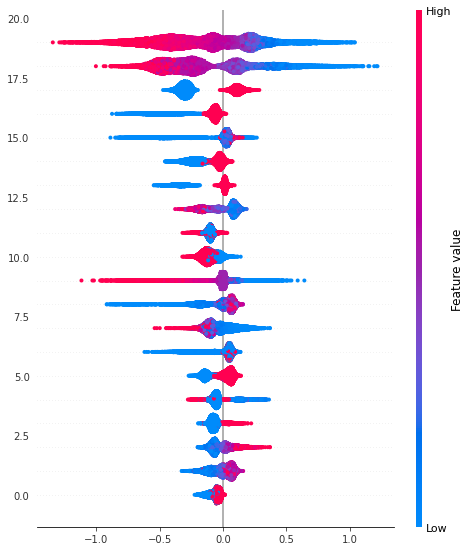

In [54]:
# Sauvegarder le meilleur modèle
joblib.dump(best_model, 'model_xgb_with_smote.pkl')

# SHAP pour expliquer les prédictions

# Initialiser un explainer SHAP
explainer = shap.TreeExplainer(best_model['model'])

# Calculer les valeurs SHAP pour les prédictions sur le jeu de test
shap_values = explainer.shap_values(X_test_preprocessed)

# Visualisation des valeurs SHAP globales pour les caractéristiques
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=X_test.columns)

# Visualisation d'un exemple spécifique
shap.initjs()
shap.force_plot(shap_values[0], X_test_preprocessed.iloc[0], feature_names=X_test.columns)



### Afficher la matrice de confusion

Vrais Positifs (TP) : 1181 : Cas où le modèle a correctement prédit la classe positive.
Faux Positifs (FP) : 5604 : Cas où le modèle a prédit à tort la classe positive.
Faux Négatifs (FN) : 602 : Cas où le modèle a prédit à tort la classe négative.
Vrais Négatifs (TN) : 14656 : Cas où le modèle a correctement prédit la classe négative.


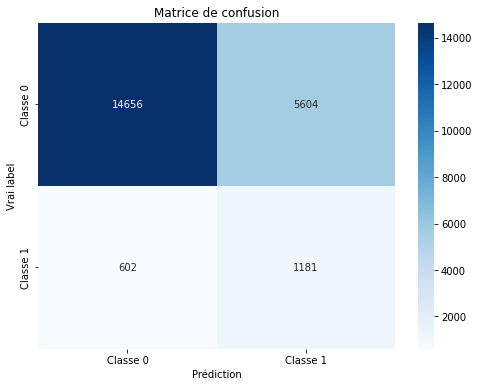

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Calculer les prédictions binaires avec le seuil optimal
y_pred_bin = (y_pred_proba >= best_threshold).astype(int)  # Appliquer le seuil optimal

# 2. Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_bin)

# Extraire TP, FP, FN, TN à partir de la matrice de confusion
TN, FP, FN, TP = cm.ravel()

# 3. Afficher les résultats
print(f"Vrais Positifs (TP) : {TP} : Cas où le modèle a correctement prédit la classe positive.")
print(f"Faux Positifs (FP) : {FP} : Cas où le modèle a prédit à tort la classe positive.")
print(f"Faux Négatifs (FN) : {FN} : Cas où le modèle a prédit à tort la classe négative.")
print(f"Vrais Négatifs (TN) : {TN} : Cas où le modèle a correctement prédit la classe négative.")

# 4. Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.title('Matrice de confusion')
plt.show()



In [ ]:
# utlisation de RandomunderSampler a la place de smote pour comparer les resultat :

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler  # Pour l'undersampling
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import joblib

# Exemple de données (remplacez par vos données)
# X_train = train_data.drop(columns=['TARGET'])
# y_train = train_data['TARGET']

# Vérification des données cibles
print("Aperçu des données cibles avant transformation :")
print(y_train.head())
print("Valeurs uniques des cibles :")
print(y_train.unique())

# Conversion de la cible en binaire si nécessaire
y_train = (y_train > 0.5).astype(int)

# Afficher la taille des données avant l'undersampling
print(f"Taille des données avant l'undersampling - X_train : {X_train.shape}, y_train : {y_train.shape}")

# Identification des variables catégorielles et numériques
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Prétraitement des données
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Imputation des NaN (numériques)
            ('scaler', StandardScaler())  # Standardisation
        ]), numerical_features),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputation des NaN (catégoriques)
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))  # Encodage OneHot
        ]), categorical_features)
    ]
)

# Gestion des classes déséquilibrées avec RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # Undersampling

# Initialisation du modèle XGBoost avec pondération des classes
model_xgb = xgb.XGBClassifier(random_state=42, scale_pos_weight=10)

# Pipeline complet : Prétraitement -> RandomUnderSampler -> Modèle
pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('rus', rus),  # Application de l'undersampling
    ('model', model_xgb)
])

# Affichage de la taille des données après l'undersampling, avant l'entraînement
# Appliquer RandomUnderSampler pour voir les effets sur la taille des données
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
print(f"Taille des données après l'undersampling - X_train : {X_train_resampled.shape}, y_train : {y_train_resampled.shape}")

# Définition de la fonction de coût métier : 10 * FN + FP
def cost_function(y_true, y_pred_proba, threshold=0.5):
    y_pred_bin = (y_pred_proba >= threshold).astype(int)  # Conversion des probabilités en classes
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()  # Matrice de confusion
    return 10 * fn + fp  # Coût métier

# Création d'un scorer basé sur la fonction de coût
def custom_cost_score(y_true, y_pred_proba, threshold=0.5):
    return -cost_function(y_true, y_pred_proba, threshold)

custom_scorer = make_scorer(custom_cost_score, greater_is_better=False)

# Grille d'hyperparamètres pour GridSearchCV
param_grid = {
    'model__n_estimators': [220],
    'model__max_depth': [7],
    'model__learning_rate': [0.1],
    'model__colsample_bytree': [0.8],
    'model__gamma': [0.1],
    'model__subsample': [0.8],
    'model__scale_pos_weight': [11],  
}

# Recherche d'hyperparamètres avec validation croisée stratifiée
grid_search = GridSearchCV(
    pipeline_xgb,
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring=custom_scorer,
    n_jobs=-1
)

# Entraînement du modèle
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres et score associé
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score de coût métier:", -grid_search.best_score_)

# Prédictions sur les données de test
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Évaluation des performances
y_pred_bin = (y_pred_proba >= 0.5).astype(int)  # Classes prédictes avec seuil de 0.5
auc_score_xgb = roc_auc_score(y_test, y_pred_proba)  # AUC
accuracy_xgb = accuracy_score(y_test, y_pred_bin)  # Accuracy
f1_xgb = f1_score(y_test, y_pred_bin)  # F1-score

# Recherche du seuil optimal pour minimiser le coût métier
thresholds = np.arange(0.0, 1.0, 0.01)
costs = [cost_function(y_test, y_pred_proba, threshold=t) for t in thresholds]
best_threshold = thresholds[np.argmin(costs)]

# Affichage des résultats
print(f'AUC : {auc_score_xgb:.4f}')
print(f'Accuracy : {accuracy_xgb:.4f}')
print(f'F1-Score : {f1_xgb:.4f}')
print(f'Seuil optimal pour le score métier : {best_threshold:.4f}')

# Sauvegarde du meilleur modèle
#joblib.dump(best_model, '/path/to/model_xgb_with_random_under_sampler.pkl')

# Afficher la matrice de confusion
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Calculer les prédictions binaires avec le seuil optimal
y_pred_bin = (y_pred_proba >= best_threshold).astype(int)  # Appliquer le seuil optimal

# 2. Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_bin)

# Extraire TP, FP, FN, TN à partir de la matrice de confusion
TN, FP, FN, TP = cm.ravel()

# 3. Afficher les résultats
print(f"Vrais Positifs (TP) : {TP} : Cas où le modèle a correctement prédit la classe positive.")
print(f"Faux Positifs (FP) : {FP} : Cas où le modèle a prédit à tort la classe positive.")
print(f"Faux Négatifs (FN) : {FN} : Cas où le modèle a prédit à tort la classe négative.")
print(f"Vrais Négatifs (TN) : {TN} : Cas où le modèle a correctement prédit la classe négative.")


### Model light lgbm with smote and score metier

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb  # Importer LightGBM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score
import joblib
import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline

# Exemple : X_train = train_data.drop(columns=['TARGET']), y_train = train_data['TARGET']

# Vérifiez le type et les valeurs de y_train
print(y_train.head())
print(y_train.unique())

# Division des données d'entraînement en X_train, X_test, y_train, y_test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Si la cible est continue, convertir en binaire (ajustez le seuil si nécessaire)
y_train = (y_train > 0.5).astype(int)  # Transformation en binaire

# 1. Définir les variables catégorielles dans le dataset
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# 2. Transformation des variables catégorielles et numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Imputer les NaN dans les variables numériques
            ('scaler', StandardScaler())  # Standardiser les variables numériques
        ]), X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()),

        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputer les NaN dans les variables catégorielles
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))  # Encodage des variables catégorielles
        ]), categorical_features)
    ])

# 3. SMOTE pour équilibrer les classes
smote = SMOTE(sampling_strategy=0.4, random_state=42)

# 4. Modèle LightGBM
model_lgb = lgb.LGBMClassifier(random_state=42, scale_pos_weight=10)

# 5. Créer un pipeline avec SMOTE dans un pipeline ImbPipeline
pipeline_lgb = ImbPipeline([
    ('preprocessor', preprocessor),  # Prétraitement des données
    ('smote', smote),  # SMOTE pour suréchantillonner les classes minoritaires
    ('model', model_lgb)  # LightGBM
])

# Fonction de coût métier (10 * FN + FP)
def cost_function(y_true, y_pred_proba, threshold=0.5):
    # Convertir les probabilités en classes binaires en fonction du seuil
    y_pred_bin = (y_pred_proba >= threshold).astype(int)

    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()

    # Coût métier : 10 * FN + FP
    return 10 * fn + fp

# Score personnalisé basé sur la fonction de coût métier
def custom_cost_score(y_true, y_pred_proba, threshold=0.5):
    return -cost_function(y_true, y_pred_proba, threshold)

# Créer un scorer pour la fonction de coût métier
custom_scorer = make_scorer(custom_cost_score, greater_is_better=False)

# Score pour l'AUC (à ajouter pour contrôle)
def auc_score(y_true, y_pred_proba):
    return roc_auc_score(y_true, y_pred_proba)

# Créer un scorer pour l'AUC
auc_scorer = make_scorer(auc_score, greater_is_better=True)

# Score pour l'accuracy (à ajouter pour contrôle)
def accuracy_score_custom(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Créer un scorer pour l'accuracy
accuracy_scorer = make_scorer(accuracy_score_custom, greater_is_better=True)

# 6. Recherche d'hyperparamètres avec GridSearchCV (optionnel)
param_grid = {
   'model__n_estimators': [120],
    'model__max_depth': [8],
    'model__learning_rate': [0.06],
    'model__colsample_bytree': [1.0],
    'model__gamma': [0.2],
}

grid_search = GridSearchCV(pipeline_lgb, param_grid, cv=StratifiedKFold(n_splits=5), 
                           scoring=custom_scorer, n_jobs=-1)

# Entraîner le modèle avec la recherche des meilleurs hyperparamètres
grid_search.fit(X_train, y_train)

# 7. Résultats de la recherche
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score de coût métier:", -grid_search.best_score_)

# 8. Prédictions et évaluation
best_model = grid_search.best_estimator_

# Prédire sur les données de test
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

from sklearn.metrics import f1_score

# Calcul des prédictions sur X_test
y_pred_bin = best_model.predict(X_test)  # Classes prédites pour la précision et le F1-score
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

# Calcul de l'AUC (Area Under the Curve)
auc_score_lgb = roc_auc_score(y_test, y_pred_proba)

# Calcul de l'Accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_bin)

# Calcul du F1-Score
f1_lgb = f1_score(y_test, y_pred_bin)

# Trouver le seuil optimal pour minimiser le coût métier
thresholds = np.arange(0.0, 1.05, 0.05)  # Tester des seuils de 0.0 à 1.0 par pas de 0.05
costs = [cost_function(y_test, y_pred_proba, threshold=t) for t in thresholds]  # Calculer le coût pour chaque seuil
best_threshold = thresholds[np.argmin(costs)]  # Trouver le seuil qui minimise le coût

# Affichage des résultats
print(f'AUC : {auc_score_lgb:.4f}')
print(f'Accuracy : {accuracy_lgb:.4f}')
print(f'F1-Score : {f1_lgb:.4f}')
print(f'Seuil optimal pour le score métier : {best_threshold:.4f}')

# Sauvegarder le modèle final
joblib.dump(best_model, '/home/machou/openclassroom/mlflow_project/models/lgb_model_with_smote_and_score_metier_etape_par_etape.pkl')


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Calculer les prédictions binaires avec le seuil optimal
y_pred_bin = (y_pred_proba >= best_threshold).astype(int)  # Appliquer le seuil optimal

# 2. Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_bin)

# Extraire TP, FP, FN, TN à partir de la matrice de confusion
TN, FP, FN, TP = cm.ravel()

# 3. Afficher les résultats
print(f"Vrais Positifs (TP) : {TP} : Cas où le modèle a correctement prédit la classe positive.")
print(f"Faux Positifs (FP) : {FP} : Cas où le modèle a prédit à tort la classe positive.")
print(f"Faux Négatifs (FN) : {FN} : Cas où le modèle a prédit à tort la classe négative.")
print(f"Vrais Négatifs (TN) : {TN} : Cas où le modèle a correctement prédit la classe négative.")

# 4. Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.title('Matrice de confusion')
plt.show()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


   Feature  Importance
28     f29      1112.0
29     f30      1058.0
7       f7       720.0
0       f0       703.0
8       f8       661.0
9       f9       644.0
10     f10       636.0
4       f4       631.0
27     f28       623.0
3       f3       606.0


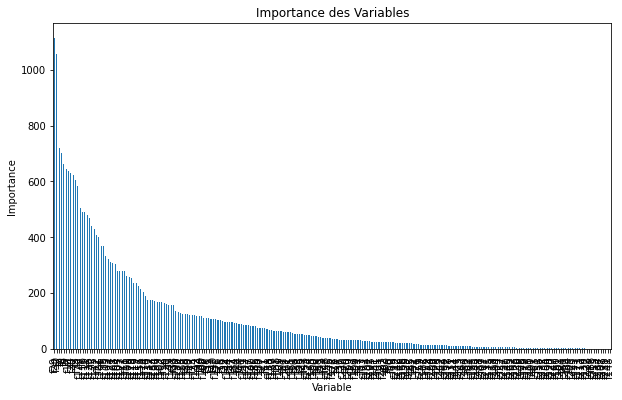

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:NAME_CONTRACT_TYPE: object, CODE_GENDER: object, FLAG_OWN_CAR: object, FLAG_OWN_REALTY: object, NAME_TYPE_SUITE: object, NAME_INCOME_TYPE: object, NAME_EDUCATION_TYPE: object, NAME_FAMILY_STATUS: object, NAME_HOUSING_TYPE: object, OCCUPATION_TYPE: object, WEEKDAY_APPR_PROCESS_START: object, ORGANIZATION_TYPE: object, FONDKAPREMONT_MODE: object, HOUSETYPE_MODE: object, WALLSMATERIAL_MODE: object, EMERGENCYSTATE_MODE: object

In [47]:
import shap
# 8. Analyse de l'importance des variables globale
importances = best_model.named_steps['model'].get_booster().get_score(importance_type='weight')
importances_df = pd.DataFrame(list(importances.items()), columns=['Feature', 'Importance'])
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Affichage des 10 variables les plus importantes
print(importances_df.head(10))

# Visualisation de l'importance des variables
importances_df.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10,6))
plt.title('Importance des Variables')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

# 9. Analyse locale avec SHAP
explainer = shap.Explainer(best_model.named_steps['model'])
shap_values = explainer(X_test)

# Visualiser l'importance locale pour la première observation
shap.initjs()
shap.force_plot(shap_values[0])

# Sauvegarder l'importance des variables dans un fichier CSV
importances_df.to_csv('/home/machou/openclassroom/mlflow_project/models/feature_importances_model_smote_score_metier_xgboost.csv', index=False)


In [48]:
import shap

# -------------------------------------
# Calcul des valeurs SHAP
# -------------------------------------

# Extraire le modèle XGBoost du pipeline
model_xgb = best_model.named_steps['model']

# Initialiser l'explainer SHAP pour XGBoost
explainer = shap.TreeExplainer(model_xgb)

# Calculer les valeurs SHAP sur X_train
shap_values = explainer.shap_values(X_train)

# Affichage de l'importance globale des caractéristiques
#shap.summary_plot(shap_values, X_train)

# Sélection des caractéristiques les plus importantes
# Ici, on choisit les 10 premières caractéristiques les plus importantes
important_features_indices = np.argsort(np.abs(shap_values).mean(axis=0))#[-10:]

# Sauvegarder les indices des caractéristiques sélectionnées
np.save('/home/machou/openclassroom/mlflow_project/models/selected_features_indices.npy', important_features_indices)

# Filtrer les données d'entrée en fonction de ces caractéristiques sélectionnées
X_train_selected = X_train.iloc[:, important_features_indices]

# Vous pouvez aussi filtrer le jeu de données de test de la même manière :
X_test_selected = X_test.iloc[:, important_features_indices]

# Affichage des 10 meilleures caractéristiques basées sur SHAP
print("Indices des caractéristiques sélectionnées par SHAP :", important_features_indices)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:NAME_CONTRACT_TYPE: object, CODE_GENDER: object, FLAG_OWN_CAR: object, FLAG_OWN_REALTY: object, NAME_TYPE_SUITE: object, NAME_INCOME_TYPE: object, NAME_EDUCATION_TYPE: object, NAME_FAMILY_STATUS: object, NAME_HOUSING_TYPE: object, OCCUPATION_TYPE: object, WEEKDAY_APPR_PROCESS_START: object, ORGANIZATION_TYPE: object, FONDKAPREMONT_MODE: object, HOUSETYPE_MODE: object, WALLSMATERIAL_MODE: object, EMERGENCYSTATE_MODE: object

/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/machou/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will

### courbe ROC 

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcul des valeurs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # fpr: taux de faux positifs, tpr: taux de vrais positifs
roc_auc = auc(fpr, tpr)  # Calcul de l'AUC

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')  # Courbe ROC
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Random Classifier')  # Classifieur aléatoire

# Ajouter des annotations
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()



Une droite plate indique peu de lien entre le montant du crédit et le défaut.

In [ ]:
### enregistrer le model dans mlflow

In [ ]:

# Lancer un run MLflow
with mlflow.start_run(run_name="XGBoost_with_SMOTE_and_Cost_Score") as run:
    
    # Enregistrer les paramètres (hyperparamètres du modèle)
    mlflow.log_param("n_estimators", 150)
    mlflow.log_param("max_depth", 8)
    mlflow.log_param("learning_rate", 0.06)
    mlflow.log_param("subsample", 1.0)
    mlflow.log_param("colsample_bytree", 1.0)
    mlflow.log_param("gamma", 1)
    mlflow.log_param("min_child_weight", 5)
    mlflow.log_param("scale_pos_weight", 10)
    mlflow.log_param("reg_alpha", 0.01)
    mlflow.log_param("reg_lambda", 1.0)
    
    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc", auc_score)
    mlflow.log_metric("cost_metric", min_cost)
    mlflow.log_metric("optimal_threshold", best_threshold)

    # Tracer et enregistrer des graphiques
    plt.figure()
    RocCurveDisplay.from_predictions(y_test, y_pred_proba_xgb, name=f"ROC curve (AUC = {auc_score:.2f})")
    plt.savefig("roc_curve.png")
    mlflow.log_artifact("roc_curve.png")  # Enregistrer le graphique ROC dans MLflow

    # Enregistrer le modèle XGBoost dans MLflow avec signature et exemple d'entrée
    mlflow.xgboost.log_model(
        best_model.named_steps['model'],  # Enregistrez le modèle (assurez-vous que votre modèle est le bon dans le pipeline)
        "xgboost_model",
        signature=signature,
        input_example=input_example
    )

    # Ajouter une note au run pour documenter le seuil métier
    mlflow.set_tag("business_optimal_threshold", f"{best_threshold:.4f}")

print("Modèle et métriques enregistrés dans MLflow avec signature et exemple d'entrée.")

